# MySQL IMDb database querying and data visualisation

**(A WORK IN PROGRESS)**

In this notebook we query the IMDb database to explore and visualise the IMDb dataset using pandas and matplotlib. 
This notebook is by no means a thorough exploration of the IMDb dataset. Its purpose is to practice querying a database using python, then to process and visualise the retrieved data with the pandas package. In particular, we consider the following questions:

- What are the average ratings for the TV show 'The X-files'?
- What genres are there? 
- How many movies are there in each genre?
- How many movies are made in each genre each year?
- How do the average ages of leading actors and actresses compare in each genre?
- What is a typical runtime for movies in each genre?

## Imports

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt # general plotting
import matplotlib as mpl # for figure quality (dpi)
import os

## Formatting

In [2]:
# Fontsize
fs = 12

# Figure quality
mpl.rcParams['figure.dpi']= 100 # in notebook resolution
mpl.rc("savefig", dpi=400) # higher resolution when saving

# Set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# Set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']= 1
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

## Image folder for storing plots

In [3]:
# Create directory if doesn't already exist
img_directory = './images/plots'
if not os.path.exists(img_directory):
    os.mkdir(img_directory)
    print("Directory: " , img_directory ,  " created.")

## Connect to IMDb database 

In [4]:
mydb = mysql.connector.connect(
    host='localhost',
    user='root',
    passwd='dopey_dwarf',
    auth_plugin='mysql_native_password',
    database='IMDb') 

Database cursor 

In [5]:
mycursor = mydb.cursor()

Show tables in the IMDb database by executing the simple statement

In [6]:
mycursor.execute("SHOW TABLES;")

In [7]:
tables = mycursor.fetchall()

In [8]:
print('IMDb Database contains the following tables:')
print('--------------------------------------------')
for table in tables:
    print(table[0])

IMDb Database contains the following tables:
--------------------------------------------
Alias_attributes
Alias_types
Aliases
Directors
Episode_belongs_to
Had_role
Known_for
Leading_people
Name_worked_as
Names_
Principals
q1
q10
q11
q12
q13
q14
q15
q16
q17
q18
q19
q2
q20
q21
q22
q23
q24
q3
q4
q5
q6
q7
q8
q9
Title_genres
Title_ratings
Titles
Writers


## Visualising the ratings of the tv show "The X-Files"

What is the average rating of each episode of The X-Files? 

In [9]:
Query1 = """SELECT E.season_number, E.episode_number, T2.primary_title, R.average_rating
FROM Titles AS T1, Titles AS T2, Episode_belongs_to AS E, Title_ratings AS R
WHERE T1.primary_title = 'The X-Files'
AND T1.title_type = 'tvSeries'
AND T1.title_id = E.parent_tv_show_title_id
AND T2.title_type = 'tvEpisode'
AND T2.title_id = E.episode_title_id
AND T2.title_id = R.title_id
ORDER BY E.season_number, E.episode_number;"""

In [10]:
mycursor.execute(Query1)

In [11]:
data = mycursor.fetchall()

In [12]:
df = pd.DataFrame(data,columns=['season_no','episode_no','ep_title','avg_rating'])

In [13]:
df.head()

,season_no,episode_no,ep_title,avg_rating
0,1,1,Pilot,8.4
1,1,2,Deep Throat,8.2
2,1,3,Squeeze,8.7
3,1,4,Conduit,7.7
4,1,5,The Jersey Devil,7.1


How many episodes were there in The X-Files per season? And what was the average of the average episode ratings for each season?

In [14]:
Query2 = """SELECT Q22.season_number, COUNT(*) AS Number_of_episodes, AVG(Q22.average_rating) AS Average_of_ep_average_ratings
FROM Q22
GROUP BY Q22.season_number
ORDER BY Q22.season_number;"""

In [15]:
mycursor.execute(Query2)

In [16]:
data = mycursor.fetchall()

In [17]:
df2 = pd.DataFrame(data,columns=['season_no','no_of_eps','avg_of_avg_ratings'])

In [18]:
df2.head()

,season_no,no_of_eps,avg_of_avg_ratings
0,1,24,7.812500
1,2,25,8.008000
2,3,24,8.191667
3,4,24,8.170833
4,5,20,8.295000


In [19]:
df2['total_eps_so_far'] = df2['no_of_eps'].cumsum()

In [20]:
df2.head()

,season_no,no_of_eps,avg_of_avg_ratings,total_eps_so_far
0,1,24,7.812500,24
1,2,25,8.008000,49
2,3,24,8.191667,73
3,4,24,8.170833,97
4,5,20,8.295000,117


We will plot the results of the above two queries to illustrate the average ratings of The X-files episodes.

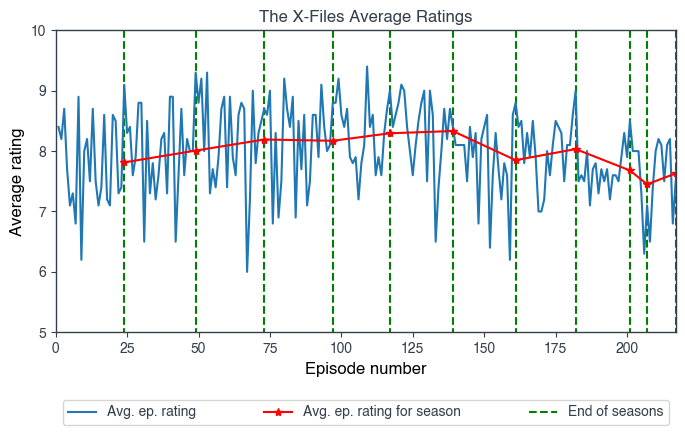

In [21]:
fig = plt.figure(figsize=(8,4))
ax = plt.gca()

# Plot average ep. rating
ax.plot(df.index+1,df.avg_rating,label='Avg. ep. rating')

# Plot the average of the average ep. rating for each season
ax.plot(df2['total_eps_so_far'],df2['avg_of_avg_ratings'],linestyle='-',marker='*',color='red',label='Avg. ep. rating for season')

# Draw vertical lines marking the end of a season 
ax.vlines(df2['total_eps_so_far'], ymin=0, ymax=10,linestyle='--', colors='g',label='End of seasons')

# Limits
ax.set_ylim([5,10])
ax.set_xlim([0,df2['total_eps_so_far'].iloc[-1]])

# Labels
plt.xlabel('Episode number',fontsize=fs)
plt.ylabel('Average rating',fontsize=fs)
plt.title('The X-Files Average Ratings',fontsize=fs)

# Legend 
ax.legend(loc='lower left',mode='expand',ncol=3,bbox_to_anchor=(0,-0.33,1,1))

# Save it
plt.savefig(os.path.join(img_directory,'The_X-Files_ratings.png'), bbox_inches="tight")

## Genres 

### What genres are there? How many movies are there in each genre?

In [22]:
Query3 ="""SELECT G.genre, COUNT(G.genre) AS Count
FROM Title_genres AS G, Titles AS T
WHERE T.title_id = G.title_id
AND T.title_type = 'movie'
GROUP BY genre
ORDER BY Count DESC;"""

In [23]:
mycursor.execute(Query3)

In [24]:
data = mycursor.fetchall()

In [25]:
df3 = pd.DataFrame(data,columns=['Genre','No. of movies'])

In [26]:
df3.head(9)

,Genre,No. of movies
0,Drama,189317
1,Documentary,100157
2,Comedy,92269
3,Action,45338
4,Romance,39742
5,Thriller,34563
6,Crime,30647
7,Horror,27841
8,Adventure,24340


In [27]:
genres = df3.Genre

We will visualise this using a horizontal bar chart

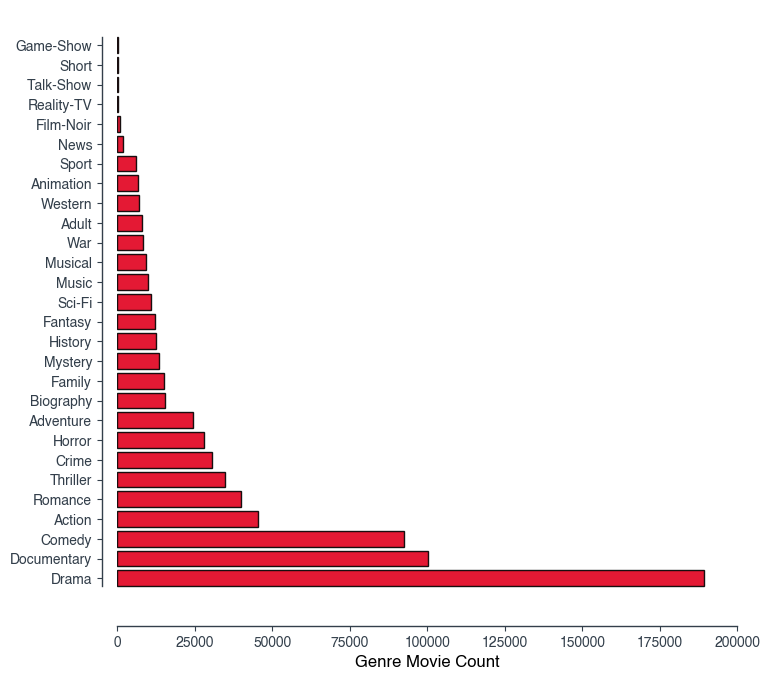

In [28]:
fig = plt.figure(figsize=(8,8))

# Bar chart
plt.barh(df3['Genre'],df3['No. of movies'], align='center',
         alpha=0.9,color='#E1001E',edgecolor='black')

# Limit
plt.xlim([0,200000])

# X label
plt.xlabel('Genre Movie Count',fontsize=fs)

# Change the style of the axis spines
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# Set the spines position
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_position(('axes', -0.025))

# Save it
plt.savefig(os.path.join(img_directory,'Genre_movie_count.png'), bbox_inches="tight")

### How many movies are made in each genre each year?

In [29]:
Query4 ="""SELECT T.start_year, G.genre, COUNT(DISTINCT T.title_id) AS Number_of_movies
FROM Titles AS T, Title_genres AS G
WHERE T.title_id = G.title_id
AND T.title_type = 'movie'
AND T.start_year <= 2019
GROUP BY T.start_year, G.genre
ORDER BY T.start_year DESC, G.genre ASC;"""

In [30]:
mycursor.execute(Query4) 

In [31]:
data = mycursor.fetchall()

In [32]:
df4 = pd.DataFrame(data,columns=['Year','Genre','Number of movies'])

In [33]:
df4.head()

,Year,Genre,Number of movies
0,2019,Action,1061
1,2019,Adult,66
2,2019,Adventure,505
3,2019,Animation,353
4,2019,Biography,442


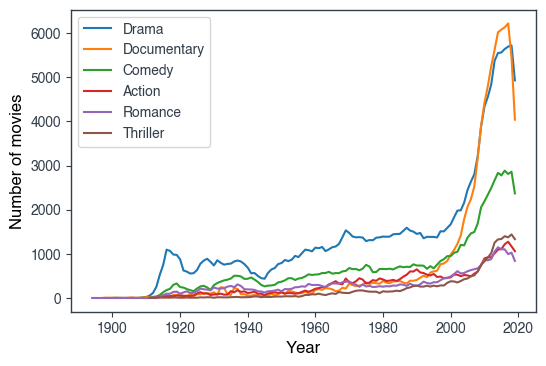

In [34]:
fig = plt.figure(figsize=(6,4))

# For each genre g in genres (only consider the top 6 genres)
for g in genres[:6]:
    
    # Data for a particular genre 
    g_df = df4[df4.Genre.str.contains(g)]

    # Plot number of movies for this genre vs year 
    plt.plot(g_df['Year'],g_df['Number of movies'],label=g)

# Legend
plt.legend()

# Labels
plt.xlabel('Year',fontsize=fs)
plt.ylabel('Number of movies',fontsize=fs)

# Save it
plt.savefig(os.path.join(img_directory,'Genre_movie_count_vs_year.png'), bbox_inches="tight")

### How do the average ages of leading actors and actresses compare in each genre?

We limit ourselves to movies between 1919 and 2019. To determine the age of an actor/actress when the movie was being made the title start year and the birth year of the person must both be non-NULL. If either of these are NULL, then that entry is neglected.

First we create an intermediate table `Leading_people` with 'year','title_id','job_category', and 'ordering' data. We then query this table to combine this with 'age' and 'genre' information.

In [35]:
mycursor.execute("""DROP TABLE IF EXISTS Leading_people;""")

In [36]:
Query5 = """CREATE TABLE  Leading_people
AS SELECT T.start_year, T.title_id, P.job_category, MIN(P.ordering) AS ordering
FROM Titles AS T, Principals AS P, Names_ AS N
WHERE T.title_id = P.title_id
AND P.job_category IN ('actor','actress')
AND T.title_type = 'movie'
AND T.start_year IS NOT NULL
AND N.birth_year IS NOT NULL
AND N.name_id = P.name_id
AND T.start_year BETWEEN 1919 AND 2019 
GROUP BY T.title_id, P.job_category
ORDER BY T.start_year, T.title_id;"""

In [37]:
mycursor.execute(Query5)

In [38]:
Query6 = """SELECT L.*, T.start_year - N.birth_year AS age, G.genre
FROM Leading_people AS L, Names_ AS N, Titles AS T, Principals AS P, Title_genres AS G
WHERE L.title_id = T.title_id
AND P.title_id = L.title_id
AND P.name_id = N.name_id
AND P.ordering = L.ordering
AND T.title_id = G.title_id ;"""

In [39]:
mycursor.execute(Query6)

In [40]:
data = mycursor.fetchall()

In [41]:
df6 = pd.DataFrame(data,columns=['year','title_id','job_category','ordering','age','genre'])

In [42]:
df6.head()

,year,title_id,job_category,ordering,age,genre
0,1919,tt0002423,actress,1,22,Biography
1,1919,tt0002423,actress,1,22,Drama
2,1919,tt0002423,actress,1,22,Romance
3,1919,tt0002423,actor,2,35,Biography
4,1919,tt0002423,actor,2,35,Drama


Let's group by year, job_category (actor/actress, i.e., gender) and also genre using pandas' groupby function

In [43]:
df_ages = df6[['year','job_category','genre','age']].groupby(by=['year','job_category','genre'])

We define two functions which will be pass to the aggregrate function. These functions will be used to calculate the first and third quartile.

In [44]:
def Q1(x):
    """The first quartile = 0.25 quantile = 25 th percentile."""
    return x.quantile(q=0.25)

In [45]:
def Q3(x):
    """The third quartile = 0.75 quantile = 75 th percentile."""
    return x.quantile(q=0.75)

In [46]:
df = df_ages.agg({'age': ['mean','median', Q1,Q3]}).reset_index()

Rename columns 

In [47]:
df.columns = ['year','job_category','genre','mean','median','Q1','Q3']

In [48]:
df.head()

,year,job_category,genre,mean,median,Q1,Q3
0,1919,actor,Action,37.309091,34.0,30.50,43.00
1,1919,actor,Adventure,36.416667,35.0,31.75,42.00
2,1919,actor,Biography,46.250000,47.0,38.00,55.25
3,1919,actor,Comedy,36.203175,34.0,30.00,41.00
4,1919,actor,Crime,37.457746,36.0,30.00,43.00


In [49]:
def genre_age_plot(g,df):
    """Plotting function for individual plot."""
    
    # Men
    genre_actors = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actor'))][['year','mean','Q1','Q3']]
    
    # Women 
    genre_actresses = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actress'))][['year','mean','Q1','Q3']]
    
    # Plot mean 
    plt.plot(genre_actors['year'],genre_actors['mean'],color='blue')
    
    # Fill area between first and third quartiles 
    plt.fill_between(genre_actors['year'], genre_actors['Q1'], 
                     genre_actors['Q3'], facecolor='blue', alpha=0.2,label='actor')

    # Plot mean 
    plt.plot(genre_actresses['year'],genre_actresses['mean'],color='red')
    
    # Fill area between first and third quartiles 
    plt.fill_between(genre_actresses['year'], genre_actresses['Q1'], 
                     genre_actresses['Q3'], facecolor='red', alpha=0.2,label='actress')

    # labels 
    plt.xlabel('Year',fontsize=fs)
    plt.ylabel('Age of lead actor/actress',fontsize=fs)
    plt.title(g,fontsize=fs)
    
    # Legend 
    plt.legend(loc='upper left')

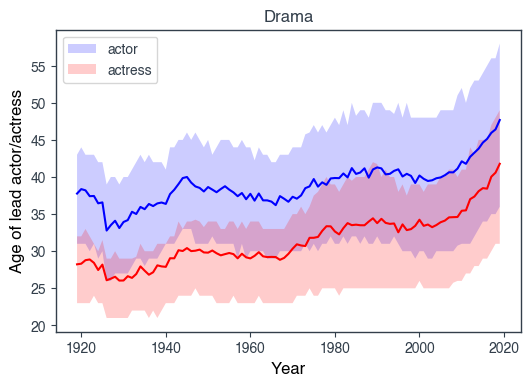

In [50]:
genre_age_plot('Drama',df)

# Save it
plt.savefig(os.path.join(img_directory,'Drama_average_age_gender.png'), bbox_inches="tight")

In [51]:
def genre_age_plot_ax(ax,g,df):
    """Plotting function to used for subplots."""
    
    # Men 
    genre_actors = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actor'))][['year','mean','Q1','Q3']]
    
    # Women 
    genre_actresses = df[(df.genre.str.contains(g)) & (df.job_category.str.contains('actress'))][['year','mean','Q1','Q3']]
    
    # Plot mean 
    ax.plot(genre_actors['year'],genre_actors['mean'],color='blue')
    
    # Fill area between first and third quartiles 
    ax.fill_between(genre_actors['year'], genre_actors['Q1'], 
                     genre_actors['Q3'], facecolor='blue', alpha=0.2,label='actor')

    # Plot mean 
    ax.plot(genre_actresses['year'],genre_actresses['mean'],color='red')
    
    # Fill area between first and third quartiles 
    ax.fill_between(genre_actresses['year'], genre_actresses['Q1'], 
                     genre_actresses['Q3'], facecolor='red', alpha=0.2,label='actress')

    # Genre title 
    ax.set_title(g,fontsize=fs)


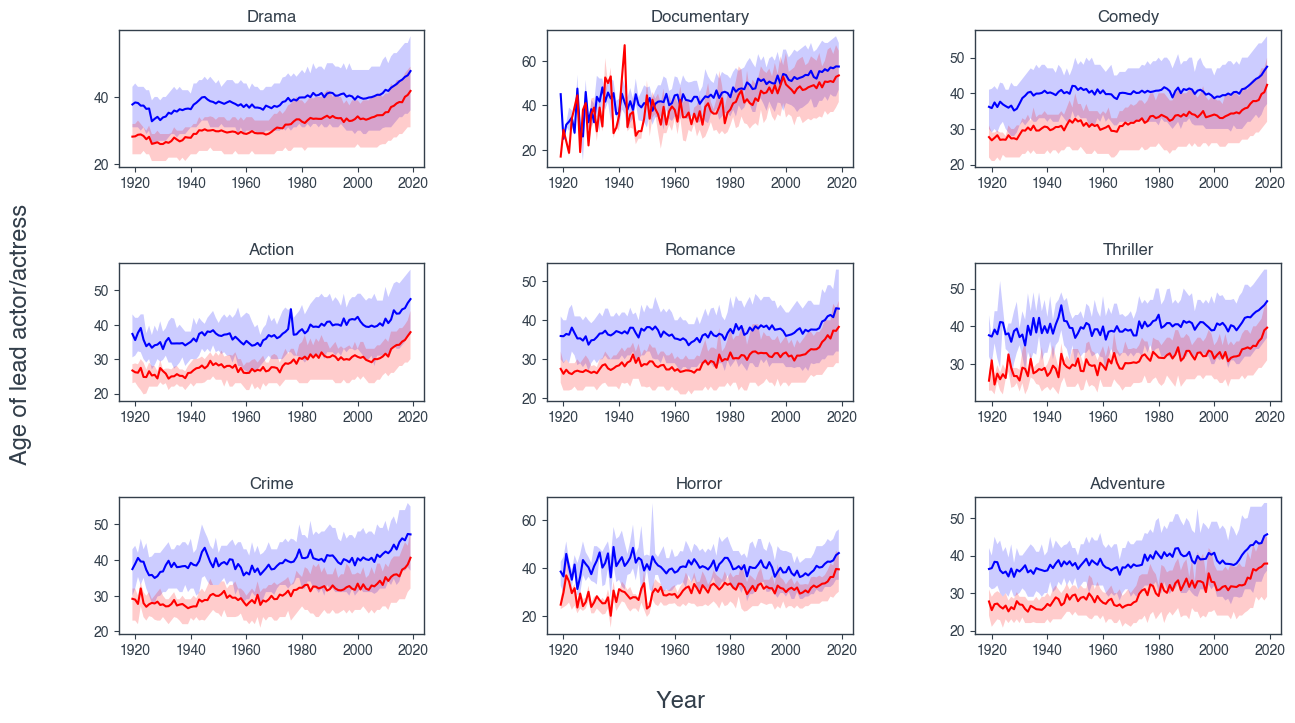

In [52]:
fig, axs = plt.subplots(3,3,figsize=(15, 8))
fig.subplots_adjust(hspace=0.7, wspace=0.4)

# Consider only the top 9 genres 
g = genres[:9] 

axs = axs.ravel()

for i in range(9): 
    genre_age_plot_ax(axs[i],g[i],df)
    
# Set common labels
fig.text(0.5, 0.04, 'Year', ha='center', va='center',fontsize=fs+5)
fig.text(0.06, 0.5, 'Age of lead actor/actress', ha='center', va='center', rotation='vertical',fontsize=fs+5)

# Save it
plt.savefig(os.path.join(img_directory,'Top_9_genres_average_age_gender.png'), bbox_inches="tight")

### What is a typical runtime for movies in each genre?

In [53]:
Query7 ="""SELECT G.genre, T.runtime_minutes 
FROM Titles AS T, Title_genres AS G 
WHERE T.runtime_minutes IS NOT NULL
AND T.title_type = 'movie'
AND T.title_id = G.title_id; """

In [54]:
mycursor.execute(Query7)

In [55]:
data = mycursor.fetchall()

In [56]:
df7 = pd.DataFrame(data,columns=['genre','runtime_minutes'])

In [57]:
df7.head()

,genre,runtime_minutes
0,Romance,45
1,Documentary,20
2,News,20
3,Sport,20
4,Biography,70


Some titles have extremely large and unrelistic values, to ignore these we introduce a cutoff for the runtime_minutes.

In [58]:
cutoff = 300 

Histogram using matplotlib

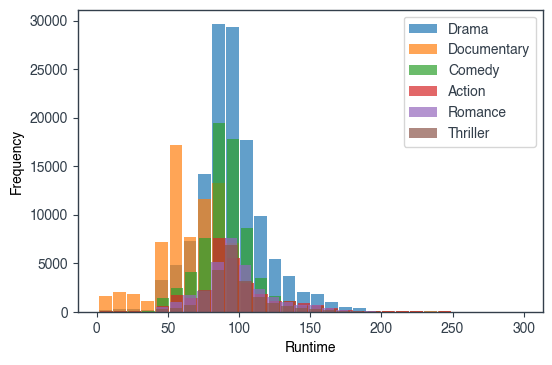

In [59]:
fig = plt.figure(figsize=(6,4))

# Only consider the top 6 genres 
for g in genres[:6]:

    # Series contain genre g runtime data 
    sg = df7[df7.genre.str.match(g) & (df7['runtime_minutes'] < cutoff)]['runtime_minutes']

    # Plot histogram for g using matplotlib
    n, bins, patches = plt.hist(sg,bins=30,alpha=0.7,rwidth=0.9,label=g)

# Labels 
plt.xlabel('Runtime')
plt.ylabel('Frequency')

# Legend 
plt.legend()

Matplotlib via pandas

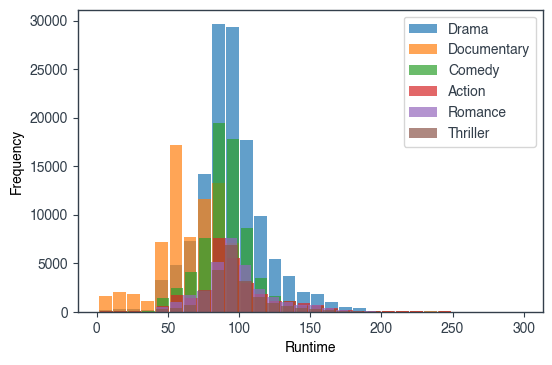

In [60]:
fig = plt.figure(figsize=(6,4))

# Only consider the top 6 genres 
for g in genres[:6]:

    # Series contain genre g runtime data 
    sg = df7[df7.genre.str.match(g) & (df7['runtime_minutes'] < cutoff)]['runtime_minutes']

    # Plot histogram for g using pandas/matplotlib 
    sg.plot.hist(grid=False, bins=30, rwidth=0.9,alpha=0.7,label=g)

# Label     
plt.xlabel('Runtime')

# Legend 
plt.legend()

# Save it
plt.savefig(os.path.join(img_directory,'Top_6_genres_runtime_hist.png'), bbox_inches="tight")

## Close database 

In [61]:
mycursor.close()

True

In [62]:
mydb.close()